In [ ]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

df = pd.read_csv("phiusiil+phishing+url+dataset.zip", compression="zip")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [37]:
'''
FILENAME dropped since its not relevant to the data and url is removed since 
useful information from url is already extracted into feature columns
'''
df = df.drop(['FILENAME', 'URL', 'Domain', 'Title'], axis=1)

#TLD can be dropped or kept depending on how useful it is for the models, should do testing including and removing it
#df = df.drop(['TLD'], axis=1)
label_encoder = LabelEncoder()
df['TLD'] = label_encoder.fit_transform(df['TLD'])

In [38]:
df.isnull()
df.duplicated()
df.dropna()
df.drop_duplicates()

,URLLength,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,231,100.000000,1.000000,0.522907,0.061933,3,1,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,254,100.000000,0.666667,0.032650,0.050207,2,1,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,647,100.000000,0.866667,0.028555,0.064129,2,2,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,231,100.000000,1.000000,0.522907,0.057606,3,1,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,503,100.000000,1.000000,0.079963,0.059441,3,1,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,29,22,0,231,100.000000,1.000000,0.522907,0.058739,3,1,...,1,0,1,51,7,21,187,2,191,1
235791,28,21,0,647,100.000000,0.785714,0.028555,0.053834,2,2,...,1,0,0,50,1,7,88,0,31,1
235792,30,23,0,157,100.000000,1.000000,0.003319,0.063093,2,1,...,0,0,1,27,10,30,58,2,67,1
235793,55,47,0,258,28.157537,0.465116,0.000961,0.050211,3,2,...,0,0,0,0,0,3,0,0,0,0


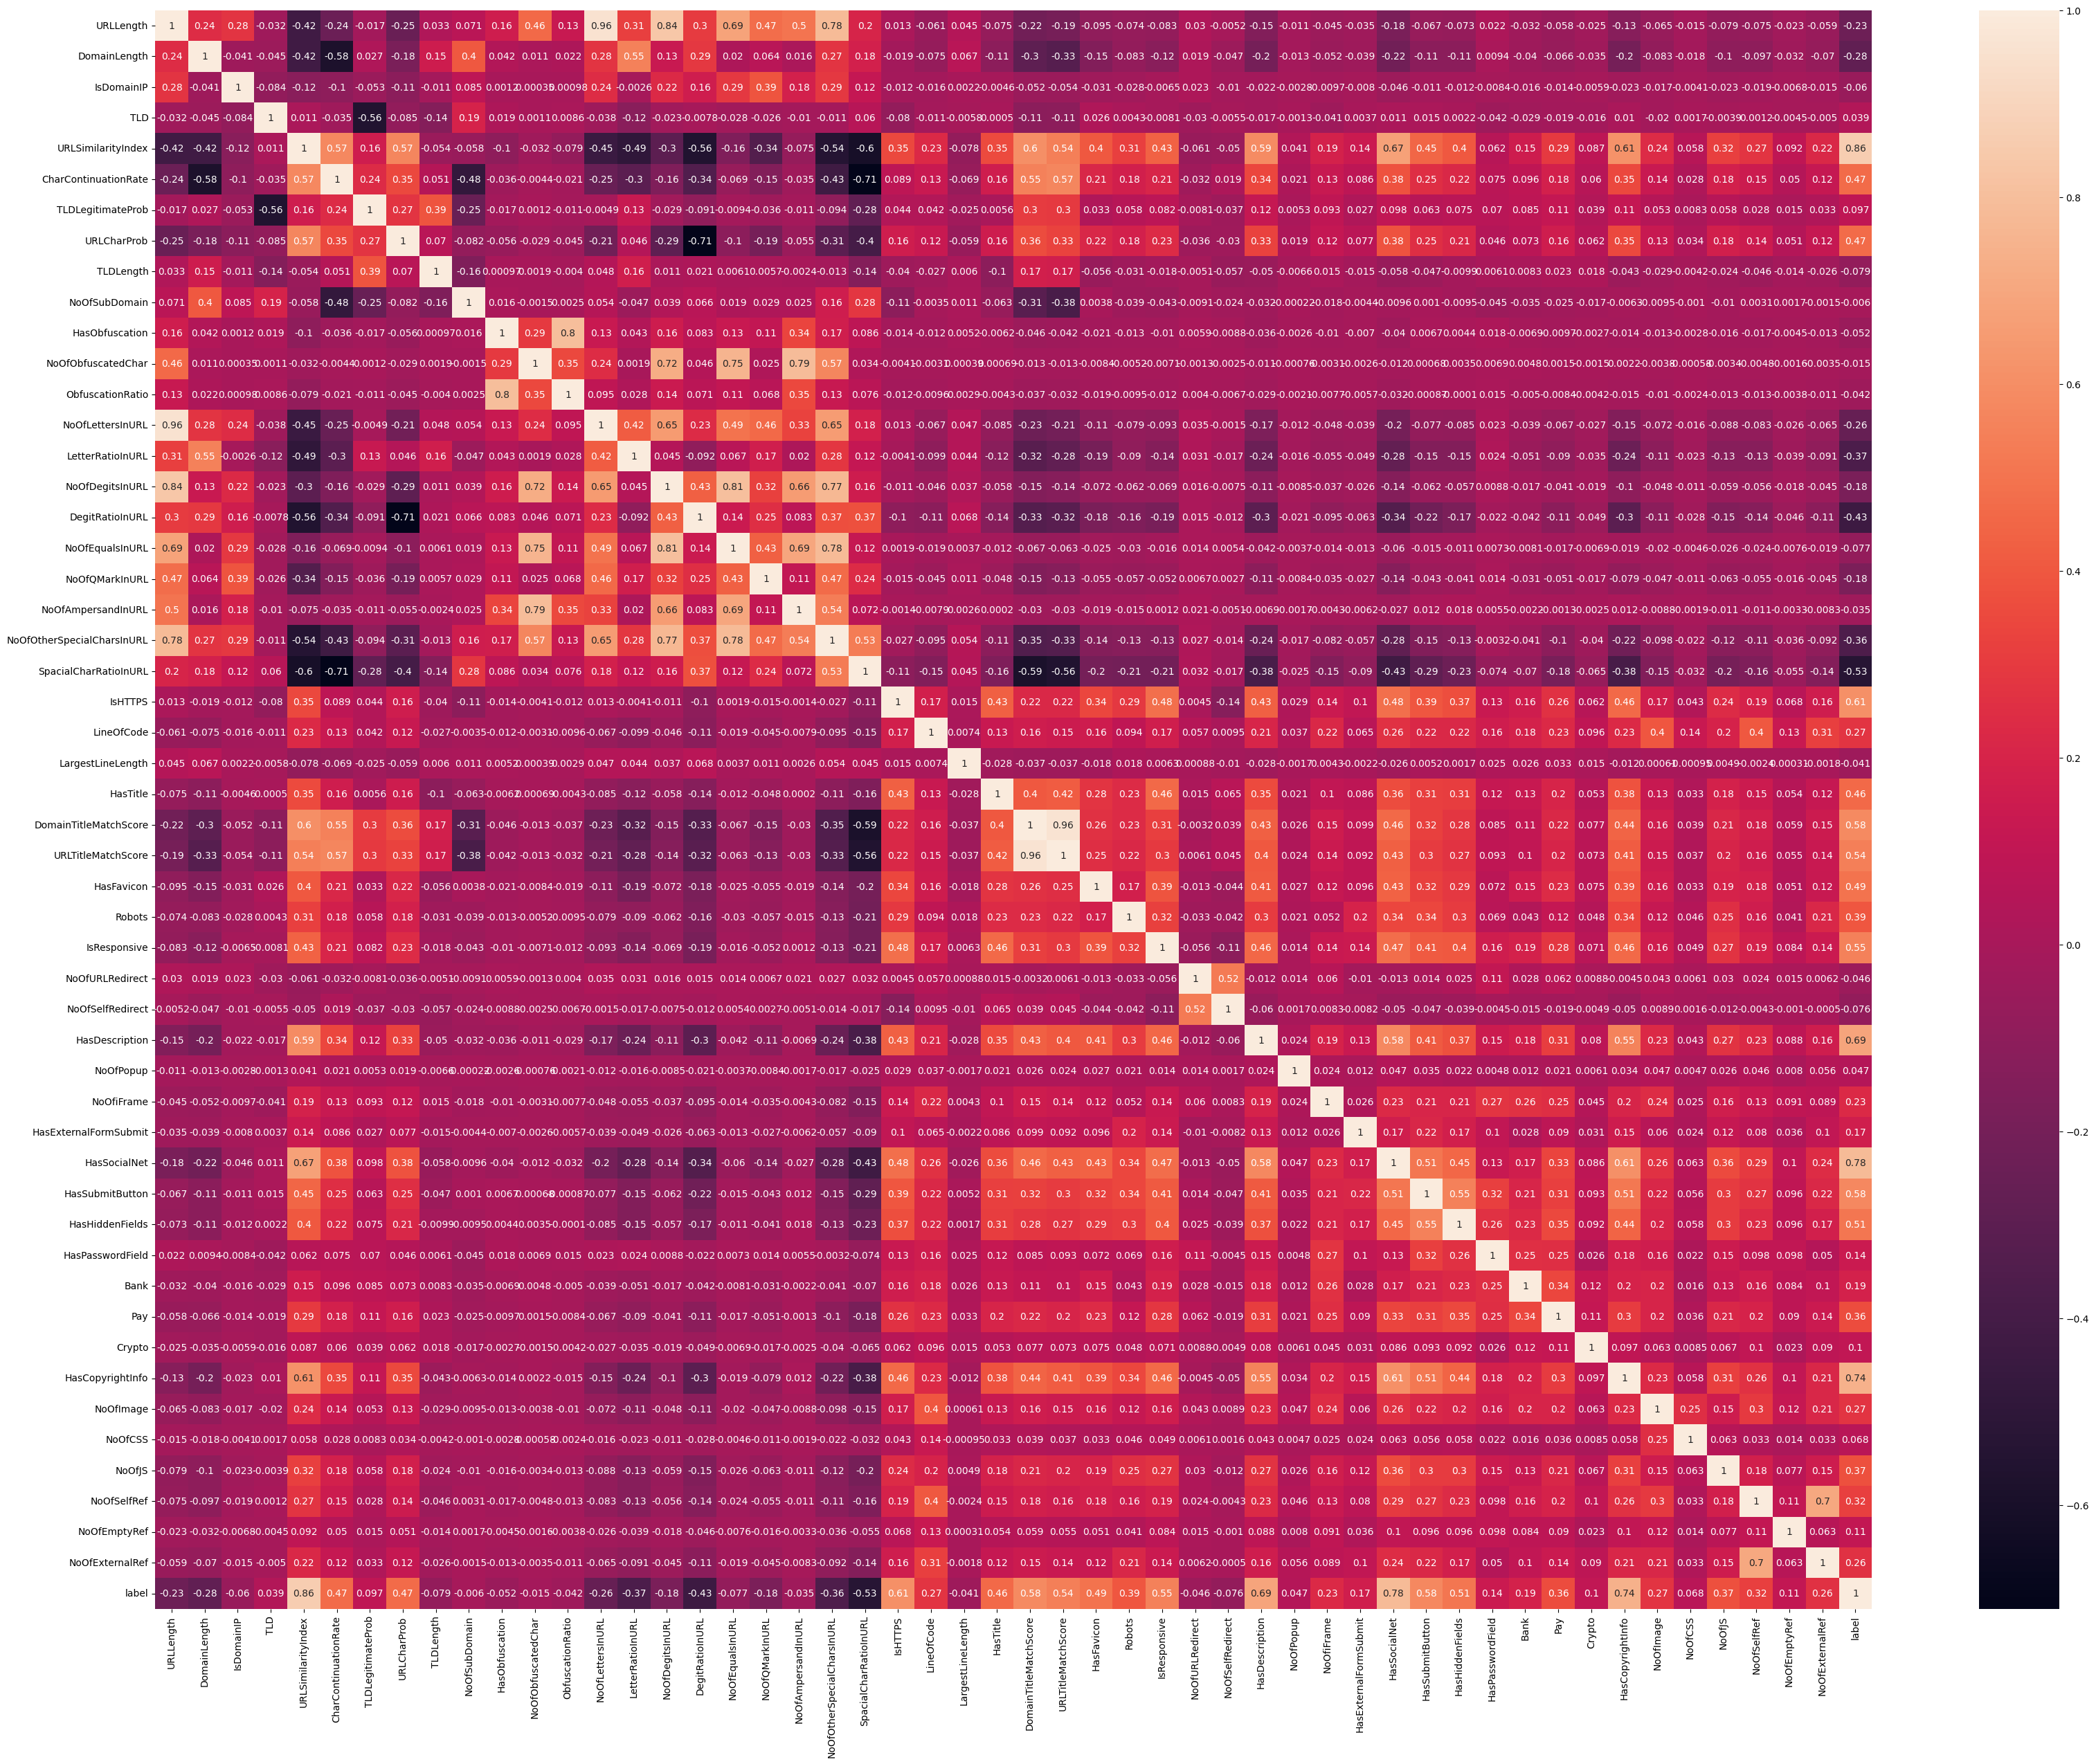

In [39]:
corr = df.corr()
plt.figure(figsize=(40, 30))
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

In [40]:
#Dropping highly corrrelated features
df = df.drop(['URLTitleMatchScore', 'URLLength', 'NoOfAmpersandInURL', 'NoOfLettersInURL'], axis=1) 

In [41]:
features_cleaned = df.copy()
for column in features_cleaned.columns:
    if df[column].nunique() <= 2 or column == 'label':
        continue

    #These features are the only one with reasonable data spreads
    if (column == 'DomainLength' or column == 'URLCharProb' or column == 'LetterRatioInURL' or column == 'SpacialCharRatioInURL'):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        #df[column].hist(bins=50)
        #plt.show()

        #Identifing outliers (points outside the bounds)
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        #Remove the outliers from the DataFrame
        features_cleaned = features_cleaned[(features_cleaned[column] >= lower_bound) & (features_cleaned[column] <= upper_bound)]


In [42]:
smaller_sample = features_cleaned.sample(frac=0.1, random_state=42)
final_features = smaller_sample.drop(['label'], axis=1)
standard_scale = StandardScaler()
standard_scale.fit(final_features)
final_features = standard_scale.transform(final_features)

#Checking data imbalance
target = smaller_sample['label']
print(target.value_counts())

smt = SMOTE()
features_res, target_res = smt.fit_resample(final_features, target)
#making sure the class imbalance was resovled
class_imbalance = target_res.value_counts()
print(class_imbalance)

train_features, test_features, train_target, test_target = train_test_split(features_res, target_res, train_size=.8)



label
1    13399
0     7877
Name: count, dtype: int64
label
1    13399
0    13399
Name: count, dtype: int64
